# Guided Projects: Predicting Bike Rentals

## Introduction

Many American cities have communal bike sharing stations where one can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

The goal of this project is to predict the total number of bikes people rented in a given hour. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

## Librairies Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The Data

Hadi Fanaee-T at the University of Porto compiled these data into a CSV file, which we'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data are available for download on the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

* `instant` - A unique sequential ID number for each row
* `dteday` - The date of the rentals
* `season` - The season in which the rentals occurred
* `yr` - The year the rentals occurred
* `mnth` - The month the rentals occurred
* `hr` - The hour the rentals occurred
* `holiday` - Whether or not the day was a holiday
* `weekday` - The day of the week (as a number, 0 to 7)
* `workingday` - Whether or not the day was a working day
* `weathersit` - The weather (as a categorical variable)
* `temp` - The temperature, on a 0-1 scale
* `atemp` - The adjusted temperature
* `hum` - The humidity, on a 0-1 scale
* `windspeed` - The wind speed, on a 0-1 scale
* `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* `registered` - The number of registered riders (people who had already signed up)
* `cnt` - The total number of bike rentals (casual + registered)

Let's start by reading the data in!

In [3]:
bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Initial Data Exploration

We start by taking a look at the distribution of the total number of rentals per hour.

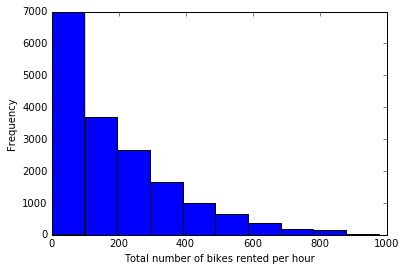

In [4]:
plt.hist(bike_rentals["cnt"])
plt.xlabel("Total number of bikes rented per hour")
plt.ylabel("Frequency")
plt.show()

We then explore how each column in the dataframe is correlated with `cnt`.

In [24]:
bike_rentals.corr(method="pearson")["cnt"].sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

We can see that the `registered` and `casual` columns strongly correlate with `cnt`. This makes sense as `cnt` is the result of the sum of these two columns. The `registered` column correlates better than the `casual` column. If we consider a registered user, the probability that he will use the service at a given instant is higher than for a casual user.

Columns on temperature and hour of rental also strongly correlate with the number of rentals per hour. These are important factors that help predict if a lot of riders are gonna use the service or not at a given instant.

Interestingly, the type of day (whether is it a working day, a week day or a holiday day) doesn't affect the total number of rentals much. These columns don't correlate strongly with `cnt`.

## Features Engineering

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the `hr` column in `bike_rentals` contains the hours during which bikes are rented, from 0 to 23. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with integers to identify the different periods of the day: morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

We create a function to perform this conversion.

In [31]:
def assign_label(hour):
    if (hour >= 0) & (hour < 6):
        return 1
    elif (hour >= 6) & (hour < 12):
        return 2
    elif (hour >= 12) & (hour < 18):
        return 3    
    elif (hour >= 18) & (hour < 24):
        return 4

We apply this function to the `hr` column and create a new column named `time_label`.

In [32]:
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1


## Train/Test Split

Before we can begin applying machine learning algorithms, we need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set. If we train an algorithm on the training data, then evaluate its performance on the same data, we can get an unrealistically low error value, due to overfitting.

We decide to keep 80% of the data for training and only 20% for testing.

In [49]:
train = bike_rentals.sample(frac=.8, axis=0)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

print(bike_rentals.shape)
print(train.shape)
print(test.shape)

(17379, 18)
(13903, 18)
(3476, 18)


## Error Metric

Before training any model, we need to choose the most appropriate metric to evaluate it.

The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [5]:
from sklearn.metrics import mean_squared_error

## Models Training and Evaluation

In this section, we train different models and evaluate their performance.

For training, we'll need to ignore the `casual` and `registered` columns because `cnt` is derived from them. If we're trying to predict the number of people who rent bikes in a given hour (`cnt`), it doesn't make sense that we'd already know `casual` or `registered`
, because those numbers are added together to get cnt.

We start by a linear regression model.

### Linear Regression

Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

Let's start by creating a list of predictor columns to use in training and predictions. We decide to keep all the columns except for `casual`, `registered` and `dteday` (the date of the rentals).

In [51]:
features = list(bike_rentals.columns)
features.remove("cnt")
features.remove("casual")
features.remove("dteday")
features.remove("registered")
print(features)

['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']


We then train a linear regression model on the train set for these features and evaluate it on the test set.

In [55]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train[features], train["cnt"])
predictions = lr.predict(test[features])

mse = mean_squared_error(test["cnt"], predictions)
print(mse)

19907.556547288335


The error is very high, which may be due to the fact that the data set has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

Let's now try with a decision tree algorithm.

### Decision Tree

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

Let's train and evaluate a decision tree model. We train it with different values of minimum samples per leaf.

In [75]:
from sklearn.tree import DecisionTreeRegressor

min_samples_leaf = range(1,11)

mse_values = {}

for v in min_samples_leaf:
    dt = DecisionTreeRegressor(min_samples_leaf=v)
    dt.fit(train[features], train["cnt"])
    predictions = dt.predict(test[features])
    mse = mean_squared_error(test["cnt"], predictions)
    mse_values[v] = mse

mse_values

{1: 3200.2853855005756,
 2: 2927.0806642373095,
 3: 2622.0142667178116,
 4: 2522.504068734034,
 5: 2464.0137963163656,
 6: 2475.0805829566207,
 7: 2537.5845431470525,
 8: 2636.593789330176,
 9: 2646.1189680601888,
 10: 2678.503804636726}

The decision tree regressor appears to have a much higher accuracy than the linear regressor. Tuning the `min_samples_leaf` hyperparameter helped improve the accuracy. Having a minimum of 5 samples per leaf seems to improve the prediction performance of our tree.

Finally, we apply the random forest algorithm, which improves on the decision tree algorithm.

## Random Forest

Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

Let's train and evaluate a random forest model. We try again with different values for the `min_samples_leaf` parameter. The number of estimators (decision trees in the forest) is set to 100 by default.

In [74]:
from sklearn.ensemble import RandomForestRegressor

min_samples_leaf = range(1,11)

mse_values = {}

for v in min_samples_leaf:
    rf = RandomForestRegressor(min_samples_leaf=v)
    rf.fit(train[features], train["cnt"])
    predictions = rf.predict(test[features])
    mse = mean_squared_error(test["cnt"], predictions)
    mse_values[v] = mse

mse_values

{1: 1751.0262111622555,
 2: 1707.3184342458057,
 3: 1750.3994487096204,
 4: 1834.2828363931983,
 5: 1910.4994944069279,
 6: 1913.3049738080817,
 7: 2095.433902573125,
 8: 2105.074227204268,
 9: 2328.306248017722,
 10: 2264.8185000683375}

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.
Having a minimum of 2 samples per leaf seems to yield the highest performance in this case.

## Conclusion

In this project, we trained and evaluated three models on bike rentals prediction: a linear regression model, a single decision tree regressor and a random forest regressor.

As expected, the random forest regressor did the best at predicting the number of bikes rented per instant.

Some potential next steps could be to:
* calculate additional features, such as an index combining temperature, humidity and wind speed.
* try predicting `casual` and `registered` instead of `cnt`